<a href="https://colab.research.google.com/github/Jack-The-Ripper-1820/GAN_VAE/blob/main/MNIST_GAN_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Input, Dense, Lambda, Reshape, Conv2DTranspose, Flatten
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.

In [ ]:
# Define the generator network
def make_generator_model():
    model = keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
      
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
# Define the discriminator network
def make_discriminator_model():
    model = keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
# Define the loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
#Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5

In [ ]:
#Create the generator and discriminator models
generator = make_generator_model()
discriminator = make_discriminator_model()

generator.summary()
#Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#Define a checkpoint to save the model weights
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_9 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_29 (Conv2D  (None, 7, 7, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

Epoch:  0
Discriminator loss:  tf.Tensor(1.6898814, shape=(), dtype=float32)
Generator loss:  tf.Tensor(0.63762933, shape=(), dtype=float32)


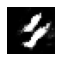

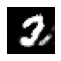

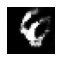

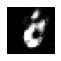

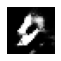

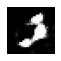

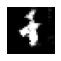

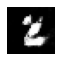

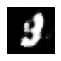

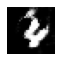

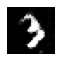

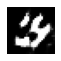

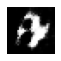

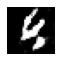

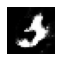

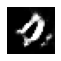

Epoch:  10
Discriminator loss:  tf.Tensor(1.3897616, shape=(), dtype=float32)
Generator loss:  tf.Tensor(0.84001034, shape=(), dtype=float32)
Epoch:  20
Discriminator loss:  tf.Tensor(1.1973838, shape=(), dtype=float32)
Generator loss:  tf.Tensor(0.88633907, shape=(), dtype=float32)
Epoch:  30
Discriminator loss:  tf.Tensor(1.4263829, shape=(), dtype=float32)
Generator loss:  tf.Tensor(0.8338063, shape=(), dtype=float32)


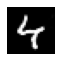

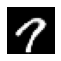

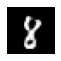

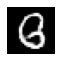

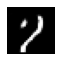

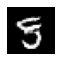

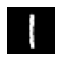

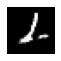

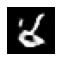

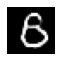

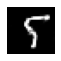

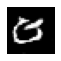

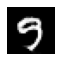

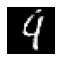

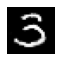

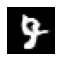

Epoch:  40
Discriminator loss:  tf.Tensor(1.1791617, shape=(), dtype=float32)
Generator loss:  tf.Tensor(0.8588594, shape=(), dtype=float32)


In [ ]:
#Train the GAN
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE = 32 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

for epoch in range(EPOCHS):
  for i in range(len(x_train) // BATCH_SIZE):
    # Get a batch of real images
    start = i * BATCH_SIZE
    end = (i + 1) * BATCH_SIZE
    real_images = x_train[start:end]
    # Generate a batch of fake images
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    fake_images = generator(noise, training=True)

    # Train the discriminator
    with tf.GradientTape() as disc_tape:
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        disc_loss = discriminator_loss(real_output, fake_output)
    grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    # Train the generator
    with tf.GradientTape() as gen_tape:
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        fake_images = generator(noise, training=True)
        fake_output = discriminator(fake_images, training=True)
        gen_loss = generator_loss(fake_output)
    grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

  # Print the loss values for every 10 epochs
  if epoch % 10 == 0:
      print("Epoch: ", epoch)
      print("Discriminator loss: ", disc_loss)
      print("Generator loss: ", gen_loss)
  # Save the model weights every 20 epochs
  if epoch % 20 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

  # Generate and plot some fake images every 30 epochs
  if epoch % 30 == 0:
      fake_images = generator(seed, training=False)
      plt.figure(figsize=(4, 4))
      for i in range(num_examples_to_generate):
          plt.subplot(4, 4, i + 1)
          plt.imshow(tf.reshape(fake_images[i], (28, 28)), cmap='gray')
          plt.axis('off')
          plt.show()


Average prediction: -0.010178292


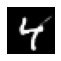

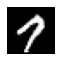

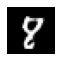

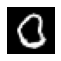

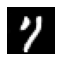

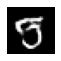

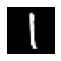

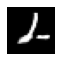

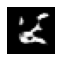

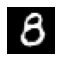

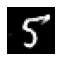

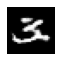

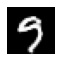

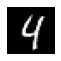

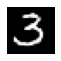

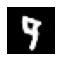

In [ ]:
fake_images = generator(seed, training=False)
predictions = discriminator(fake_images, training = False)
average_prediction = tf.reduce_mean(predictions)
print("Average prediction:", average_prediction.numpy())
plt.figure(figsize=(4, 4))

for i in range(num_examples_to_generate):
  plt.subplot(4, 4, i + 1)
  plt.imshow(tf.reshape(fake_images[i], (28, 28)), cmap='gray')
  plt.axis('off')
  plt.show()

In [ ]:
# Network parameters
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

sampling = Sampling()

# Connect encoder and decoder via the sampling layer
z_mean, z_log_var = encoder(encoder_inputs)
z = sampling([z_mean, z_log_var])
decoder_inputs = decoder(z)

# Define the VAE as a Model
vae = keras.Model(encoder_inputs, decoder_inputs, name="vae")
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="vae_loss")

history = vae.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

# Plotting the Loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()


Epoch 1/100


ValueError: ignored

In [ ]:

# # Load MNIST dataset
# (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# # Preprocess data
# x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
# x_train = (x_train - 127.5) / 127.5

# Network parameters
latent_dim = 2
input_shape = (28, 28, 1)

# Encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
x = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Use Lambda layer to apply the 'sampling' function to 'z_mean' and 'z_log_var'
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Build the encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(x)
x = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(x)
outputs = Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same', name='decoder_output')(x)

# Build the decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Instantiate VA
# Encoder network
inputs = Input(shape=(28, 28, 1), name='encoder_input')
x = Conv2D(32, 3, strides=2, padding='same', activation='relu')(inputs)
x = Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Use reparameterization trick to ensure correct gradient during backprop
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder network
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
outputs = Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# VAE as a whole
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# Add KL divergence regularization loss
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= 28 * 28
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')
vae.summary()

# Train the VAE
vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
# Encode and decode some examples from the test data
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Plot the original and decoded images
n = 10 # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
  # Display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  # Display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


NameError: ignored